## Human activities classification 

#### Import libraries 

In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
import seaborn as sns
from scipy import stats
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
from keras import regularizers
from keras.layers import Input, Dense, GlobalAveragePooling1D, MaxPooling1D
from keras.callbacks import ModelCheckpoint
from keras.layers import Conv1D, BatchNormalization, Activation, concatenate
from keras.layers import LSTM, Flatten
from keras.models import Model
from keras.optimizers import Adam
from keras.utils import to_categorical
import keras.backend as K
from keras.callbacks import Callback
from keras.callbacks import EarlyStopping
from keras.layers import TimeDistributed
from keras.layers import Bidirectional, Embedding
from keras.models import Sequential

Using TensorFlow backend.


#### Hyper-parameters 

In [2]:
RANDOM_SEED = 13

# Data preprocessing
TIME_STEP = 100

# Model
N_CLASSES = 6
N_FEATURES = 3  # x-acceleration, y-acceleration, z-acceleration

# Hyperparameters
N_LSTM_LAYERS = 2
N_EPOCHS = 15
L2_LOSS = 0.0015
LEARNING_RATE = 0.0025

# Hyperparameters optimized
SEGMENT_TIME_SIZE = 180
N_HIDDEN_NEURONS = 30
BATCH_SIZE = 32

#### Load data 
Each datum is a 3-dimensional time series (x,y and z directions of accelerometer)

In [3]:
##################################################
### GLOBAL VARIABLES
##################################################
COLUMN_NAMES = [
    'user',
    'activity',
    'timestamp',
    'x-axis',
    'y-axis',
    'z-axis'
]

LABELS = [
    'Downstairs',
    'Jogging',
    'Sitting',
    'Standing',
    'Upstairs',
    'Walking'
]

DATA_PATH = 'data/WISDM_ar_v1.1_raw.txt'
data = pd.read_csv(DATA_PATH, header=None, names=COLUMN_NAMES)
data['z-axis'].replace({';': ''}, regex=True, inplace=True)
data = data.dropna()

#### Define model 
Model 2 is inspired by Paper: "Deep Recurrent Neural Networks for Human Activity Recognition", Abdulmajid Murad, et al, 2017, Sensors MDPI
https://www.mdpi.com/1424-8220/17/11/2556

In [4]:
def model2():
    ip = Input(shape=(SEGMENT_TIME_SIZE, N_FEATURES), name='main_input')
    x = Bidirectional(LSTM(64, return_sequences=True))(ip)
    x = Bidirectional(LSTM(64))(x)
    out = Dense(N_CLASSES, kernel_regularizer=regularizers.l2(0.001), activation='softmax')(x)
    
    model = Model(ip, out)
    model.summary()
    return model

#### Training 

In [6]:
# DATA PREPROCESSING
data_convoluted = []
labels = []

# Slide a "SEGMENT_TIME_SIZE" wide window with a step size of "TIME_STEP"
for i in range(0, len(data) - SEGMENT_TIME_SIZE, TIME_STEP):
    x = data['x-axis'].values[i: i + SEGMENT_TIME_SIZE]
    y = data['y-axis'].values[i: i + SEGMENT_TIME_SIZE]
    z = data['z-axis'].values[i: i + SEGMENT_TIME_SIZE]
    data_convoluted.append([x, y, z])

    # Label for a data window is the label that appears most commonly
    label = stats.mode(data['activity'][i: i + SEGMENT_TIME_SIZE])[0][0]
    labels.append(label)

# Convert to numpy
data_convoluted = np.asarray(data_convoluted, dtype=np.float32).transpose(0, 2, 1)

# One-hot encoding
labels = np.asarray(pd.get_dummies(labels), dtype=np.float32)
print("Convoluted data shape: ", data_convoluted.shape)
print("Labels shape:", labels.shape)

# SPLIT INTO TRAINING AND TEST SETS
X_train1, X_test, y_train1, y_test = train_test_split(data_convoluted, labels, test_size=0.2, random_state=RANDOM_SEED)
X_train, X_val, y_train, y_val = train_test_split(X_train1, y_train1, test_size=0.25, random_state=RANDOM_SEED)
print("X train size: ", len(X_train))
print("X test size: ", len(X_test))
print("X val size: ", len(X_val))
print("y train size: ", len(y_train))
print("y test size: ", len(y_test))
print("y val size: ", len(y_val))
    
######### Training #########
weight_fn = "./weights_simon.h5"
model_checkpoint = ModelCheckpoint(weight_fn, verbose=1, mode='max', monitor='val_acc', save_best_only=True, save_weights_only=True)
stop = EarlyStopping(monitor='val_loss', patience=15)
callback_list = [model_checkpoint, stop]
optm = Adam(lr=LEARNING_RATE)

model = model2()

model.compile(optimizer=optm, loss='categorical_crossentropy', metrics=['accuracy'])
history = model.fit(X_train, y_train, batch_size=BATCH_SIZE, epochs=N_EPOCHS, callbacks = callback_list, verbose=2, 
                    validation_data=(X_val, y_val))

Convoluted data shape:  (10981, 180, 3)
Labels shape: (10981, 6)
X train size:  6588
X test size:  2197
X val size:  2196
y train size:  6588
y test size:  2197
y val size:  2196
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
main_input (InputLayer)      (None, 180, 3)            0         
_________________________________________________________________
bidirectional_1 (Bidirection (None, 180, 128)          34816     
_________________________________________________________________
bidirectional_2 (Bidirection (None, 128)               98816     
_________________________________________________________________
dense_1 (Dense)              (None, 6)                 774       
Total params: 134,406
Trainable params: 134,406
Non-trainable params: 0
_________________________________________________________________
Instructions for updating:
Use tf.cast instead.
Train on 6588 samples, validate on 2196 s

#### Prediction 

In [7]:
model.load_weights(weight_fn)
prediction = model.predict(X_test);
p_pred = np.argmax(prediction, axis=1)
p_test = np.argmax(y_test, axis=1)
    
cr = classification_report(p_test, p_pred)
cm = confusion_matrix(p_test, p_pred)
    
print("-------------------- Result -----------------------")
acc = np.sum(p_pred == p_test)/p_pred.shape[0]
print('Accuracy: ' + str(acc))
print(cr)
print(cm)

-------------------- Result -----------------------
Accuracy: 0.9312699135184342
              precision    recall  f1-score   support

           0       0.78      0.75      0.76       212
           1       0.96      0.99      0.98       676
           2       0.96      0.98      0.97       140
           3       0.99      0.88      0.93        78
           4       0.80      0.83      0.81       258
           5       0.98      0.96      0.97       833

   micro avg       0.93      0.93      0.93      2197
   macro avg       0.91      0.90      0.90      2197
weighted avg       0.93      0.93      0.93      2197

[[159   7   2   0  37   7]
 [  0 669   0   0   5   2]
 [  1   0 137   1   0   1]
 [  1   0   2  69   5   1]
 [ 22  13   1   0 214   8]
 [ 21   7   0   0   7 798]]


#### Loss and accuracy 

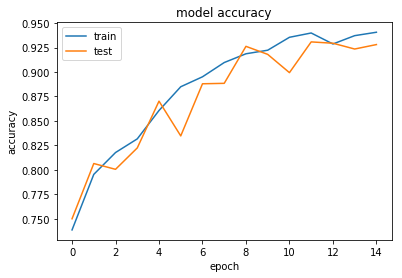

In [8]:
# summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

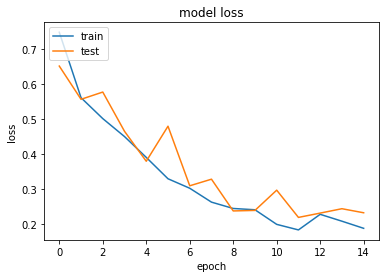

In [9]:
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

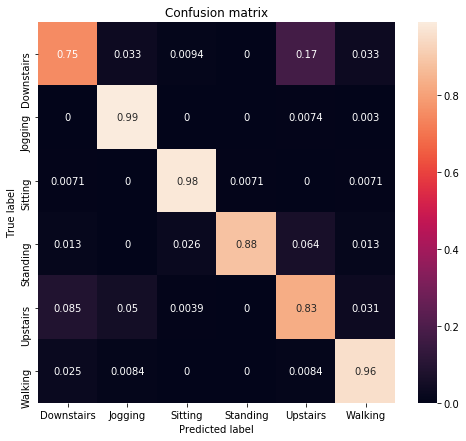

In [10]:
# CONFUSION MATRIX
plt.figure(figsize=(8, 7))
sns.heatmap(cm/(np.sum(cm, axis=1, keepdims=1)), xticklabels=LABELS, yticklabels=LABELS, annot=True);
plt.title("Confusion matrix")
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

#### Notes
Bi-directional LSTM > LSTM

FCN (aka temporal CNN) gives the best accuracy. the reason could be CNNs are more suitable for short duration data. Training LSTMs is also more computational cost compared to CNNs 